In [1]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
import model_conv_bigger
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5
import math
import scipy.stats as stats 

In [3]:
print(os.getcwd())
loghalf2pi = 0.5*math.log(2*math.pi)


/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src


In [4]:
param_file = '../../../cellbgnet/utils/reference_files/reference_Axel.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)


In [5]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']


In [6]:
psf_size = 41
xextent = [-0.5, 127.5]
yextent = [-0.5, 127.5]
zextent = [-400, 400]
scale = torch.tensor([(xextent[1] - xextent[0]),
                      (yextent[1] - yextent[0]),
                      (zextent[1] - zextent[0])])
shift = torch.tensor([xextent[0], yextent[0], zextent[0]])



In [7]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 63.5], yextent=[-0.5, 63.5], img_shape=[64, 64], device='cuda', 
roi_size=None, roi_auto_center=None, normalize=True)


INITIATING CUDA IMPLEMENTATION


In [8]:
epochs = 40
batch_size = 128
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [10]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

In [11]:
def create_psf_batch(size=64, batch_size=128):
    xyz = torch.rand((batch_size,3))*64
    #xyz = torch.ones((batch_size,3))*32
    xyz[...,2] = (torch.rand((batch_size, ))-0.5)*1000
    xyz = xyz.view(1, -1, 3)
    photon_scale = 1000
    #photons = torch.rand((xyz.shape[1], 1))*photon_scale
    photons = torch.ones((xyz.shape[1], 1))*photon_scale
    frames = torch.cat([psf.forward(xyz[:,i,...], photons[i]) for i in range(xyz.shape[1])])
    max_val = torch.max(frames)
    frames = frames/max(21.28, max_val)
    
    frames = frames.view(frames.shape[0],1,frames.shape[1], frames.shape[2])
    return frames, xyz, photons


In [12]:
frames,_, _ = create_psf_batch()
frames.max()

tensor(1.)

In [13]:
def create_batch(size=28, batch_size=64):
    batch = torch.zeros([batch_size,1,size,size])
    xys = torch.tensor([[0], [0]])
    xs = torch.randint(0, size, (batch_size,))
    ys = torch.randint(0, size,  (batch_size,))
    xys = torch.concatenate([xs.view(-1,1), ys.view(-1,1)], dim=1)
    batch[torch.arange(batch.shape[0]),0, xs, ys] = 1
    return batch, xys

In [14]:
#model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_3D_conv_B4.pt")
lr = 0.001
model = model_conv_bigger.VAE_CNN_version_2().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)

173056
(64, 64)


In [15]:
#model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_1.pt")


In [16]:
def final_loss(bce_loss, mu, logvar,beta=1, prior = None, z=None):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Let's say we estimate KL divergence with a monte carlo sampling with n=1 
    # That means that KL divergence = log(p(x|N(mu, sigma))) - log(p(z*)) where z* is the sampled z
    loglikelyhood = -0.5 *logvar - loghalf2pi - ((z-mu)/logvar).pow(2)
    prior_loglikelihood = torch.log(prior(z))
    KLD = torch.sum(loglikelyhood - prior_loglikelihood)


    return BCE + KLD*beta, BCE, KLD

In [17]:
def fit(model, dataloader, beta=1, prior=None):
    model.train()
    running_loss = 0.0
    for i in range((64*64)//batch_size):
        data = create_psf_batch()
        data, xyz, _ = data
        data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar, z = model(data)
        bce_loss = criterion(reconstruction, data)

        loss, BCE, KLD = final_loss(bce_loss, mu, logvar, beta=beta, z=z, prior=prior)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/(64*64)
    return train_loss

In [40]:
def validate(model, dataloader, prior = None):
    model.eval()
    running_loss = 0.0
    running_BCE = 0.0
    running_KLD = 0.0
    with torch.no_grad():
        for i in range((64*64)//batch_size):
            data = create_psf_batch()
            data, xys, _ = data
            data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar, z = model(data)
            bce_loss = criterion(reconstruction, data)
            loss, BCE, KLD = final_loss(bce_loss, mu, logvar, prior=prior, z=z)
            running_loss += loss.item()
            running_BCE += BCE.item()
            running_KLD += KLD.item()
            # save the last batch input and output of every epoch
            save_mod = (1+1*epoch//10) if epoch < 100 else (epoch//100)*10
            if ((64*64)//batch_size - 1) and (epoch % save_mod == 0):
                #plt.imshow(data.view(batch_size, 1, 64, 64)[0,0,...].cpu().detach().numpy(), cmap='gray')
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                                  reconstruction.view(batch_size, 1, 64, 64)[:8]))
                save_image(both.cpu(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/resnet_conv/psf_resnet_t_prior_B{beta}_{epoch}.png", nrow=num_rows, pad_value=1)

    val_loss = running_loss/(64*64)
    bce_loss_tot = running_BCE/(64*64)
    kld_loss = running_KLD/(64*64)
    return val_loss, mu, xys, bce_loss_tot, kld_loss



In [19]:
state_dict = torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/Resnet_B{2}_VAE_z_only_200.pt")
state_dict.keys()


odict_keys(['encBn1.weight', 'encBn1.bias', 'encBn1.running_mean', 'encBn1.running_var', 'encBn1.num_batches_tracked', 'encConv1.weight', 'encConv1.bias', 'encBn2.weight', 'encBn2.bias', 'encBn2.running_mean', 'encBn2.running_var', 'encBn2.num_batches_tracked', 'encConv2.weight', 'encConv2.bias', 'encBn3.weight', 'encBn3.bias', 'encBn3.running_mean', 'encBn3.running_var', 'encBn3.num_batches_tracked', 'encConv3.weight', 'encConv3.bias', 'encBn4.weight', 'encBn4.bias', 'encBn4.running_mean', 'encBn4.running_var', 'encBn4.num_batches_tracked', 'encFC1.weight', 'encFC1.bias', 'encFC2.weight', 'encFC2.bias', 'decFC1.weight', 'decFC1.bias', 'decConv1.weight', 'decConv1.bias', 'decBn1.weight', 'decBn1.bias', 'decBn1.running_mean', 'decBn1.running_var', 'decBn1.num_batches_tracked', 'decConv2.weight', 'decConv2.bias', 'decBn2.weight', 'decBn2.bias', 'decBn2.running_mean', 'decBn2.running_var', 'decBn2.num_batches_tracked', 'decConv3.weight', 'decConv3.bias'])

In [90]:
added_weights = torch.normal(0.0, 1.0, (2, 4096)).to(device)
old_weights = state_dict['encFC1.weight'].to(device)
#new_weights = torch.cat((old_weights, added_weights), dim=0)
new_weights = old_weights.repeat(3, 1)
state_dict['encFC1.weight'] = new_weights


In [91]:
state_dict['encFC1.bias'] = state_dict['encFC1.bias'].repeat(3,) 
state_dict['encFC1.bias']


tensor([-0.0128, -0.0128, -0.0128], device='cuda:0')

In [92]:
added_weights = torch.normal(0.0, 1.0, (2, 4096)).to(device)
old_weights = state_dict['encFC2.weight'].to(device)
#new_weights = torch.cat((old_weights, added_weights), dim=0)
new_weights = old_weights.repeat(3, 1)
state_dict['encFC2.weight'] = new_weights

state_dict['encFC2.bias'] = state_dict['encFC2.bias'].repeat(3,) 
state_dict['encFC2.bias']


tensor([-0.0124, -0.0124, -0.0124], device='cuda:0')

In [93]:
added_weights = torch.normal(0.0, 1.0, (4096,2)).to(device)
old_weights = state_dict['decFC1.weight'].to(device)
#new_weights = torch.cat((old_weights, added_weights), dim=1)
new_weights = old_weights.repeat(1, 3)
state_dict['decFC1.weight'] = new_weights


In [94]:
model = model_conv_bigger.VAE_CNN_version_2(zDim=3).to(device)
model.load_state_dict(state_dict)


173056
(64, 64)


<All keys matched successfully>

In [95]:
model.to(device)


VAE_CNN_version_2(
  (encBn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encBn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encBn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encBn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encFC1): Linear(in_features=4096, out_features=3, bias=True)
  (encFC2): Linear(in_features=4096, out_features=3, bias=True)
  (decFC1): Linear(in_features=3, out_features=4096, bias=True)
  (decConv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decBn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track

In [32]:
df = 3
t_1 = stats.t(1)
t_2 = stats.t(2)
t_3 = stats.t(3)
def prod_of_t(z):
    z_c = z.clone().detach().to('cpu')
    out = t_1.pdf(z_c[0])*t_2.pdf(z_c[1])*t_3.pdf(z_c[2])    
    return torch.tensor(out).to(device)


In [41]:
#train_loss = []
val_loss = []
bce_loss_list = []
kld_loss_list = []


betas = [2]
train_losses = [[] for i in range(len(betas))]
for i in range(len(betas)):
    beta = betas[i]
    batch_size = 128


    model = model_conv_bigger.VAE_CNN_version_2(zDim=3).to(device)
    #model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/Resnet_B2_VAE_z_to_xyz_600.pt"))

    curr = 0
    epochs = 400

    lr = 0.001
    #model = model_conv_bigger.VAE_CNN_version_2(zDim=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction='sum')
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min',
                                                        factor=0.2,
                                                        patience=20,
                                                        min_lr=5e-5)


    for epoch in range(curr, curr+epochs+1):
        print(f"Epoch {epoch+1} of {curr+epochs},beta = {beta}")
        train_epoch_loss = fit(model, 0, beta=beta,prior = prod_of_t)
        val_epoch_loss, mu, xys, bce_loss, kld_loss = validate(model, 0, prior=prod_of_t)
        bce_loss_list.append(bce_loss)
        kld_loss_list.append(kld_loss)
        train_losses[i].append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"BCE: {bce_loss:.4f}, KLD: {kld_loss:.4f}")
        if epoch % 100 == 0:
            torch.save(model.state_dict(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/Resnet_B{beta}_VAE_t_prior_{epoch}.pt")


173056
(64, 64)
Epoch 1 of 400,beta = 2
Train Loss: -26445.8852
BCE: 3283.0631, KLD: -11961271.4464
Epoch 2 of 400,beta = 2
Train Loss: 1472.7691
BCE: 2623.5993, KLD: -2263.5486
Epoch 3 of 400,beta = 2
Train Loss: -56931.9877
BCE: 2223.4735, KLD: -1921087.0421
Epoch 4 of 400,beta = 2
Train Loss: -1082.1715
BCE: 1470.1944, KLD: -15153.3538
Epoch 5 of 400,beta = 2
Train Loss: -4363.1916
BCE: 5033.8217, KLD: -14.1367
Epoch 6 of 400,beta = 2
Train Loss: -1264.3845
BCE: 3057.3924, KLD: -509.7304
Epoch 7 of 400,beta = 2
Train Loss: -11526.7222
BCE: 3886.2763, KLD: -119042.4981
Epoch 8 of 400,beta = 2
Train Loss: -1413.9069
BCE: 4320.0615, KLD: -293.1451
Epoch 9 of 400,beta = 2
Train Loss: -2105.0084
BCE: 2728.5090, KLD: -308.5077
Epoch 10 of 400,beta = 2
Train Loss: 1850.6405
BCE: 1665.6732, KLD: -681.0263
Epoch 11 of 400,beta = 2
Train Loss: 993.9402
BCE: 1311.2243, KLD: -329.5936
Epoch 12 of 400,beta = 2
Train Loss: 608.5180
BCE: 1080.3236, KLD: -95.3970
Epoch 13 of 400,beta = 2
Train Loss

KeyboardInterrupt: 

In [80]:
lr = 0.001
model = model_conv_bigger.VAE_CNN_version_2().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)


346112.0

In [250]:
torch.save(model, "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_z_only_resnet_conv_beta4.pt")
torch.save(model.state_dict(), "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_only_resnet_conv_beta4_sd.pt")

In [102]:
plt.plot(list(range(len(train_loss[100:]))), train_loss[100:])


type: name 'train_loss' is not defined

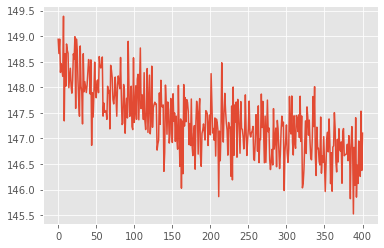

In [103]:
plt.plot(list(range(len(train_losses[0]))), train_losses[0])




In [19]:
torch.cuda.empty_cache()

In [43]:
all_xys.shape
all_mus.shape


torch.Size([11000, 2])

In [259]:
images, xys, _ = create_psf_batch(batch_size=100)
model.eval()
images = images.to(device)
reconstruction, mu, logvar = model(images)
all_xys = xys
all_mus = mu


tensor(21.2703)


tensor(0., device='cuda:0')

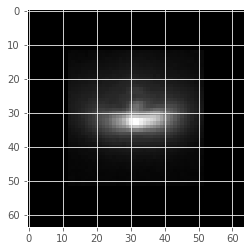

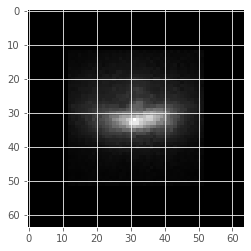

In [234]:
plt.imshow(images[0, 0,:, :].cpu(), cmap='gray')
plt.show()
plt.imshow(reconstruction[0, 0,:, :].detach().cpu(), cmap='gray')


(array([[64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  

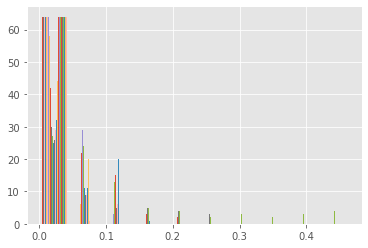

In [25]:
model = model_conv_bigger.VAE_CNN_version_2().to(device)

model.load_state_dict(torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/Resnet_B2_VAE_z_to_xyz_1000.pt"))


images, xys, _ = create_psf_batch(batch_size=100)
model.eval()
images = images.to(device)
reconstruction, mu, logvar = model(images)
all_xys = xys
all_mus = mu
for i in range(10):
    images, xys, _ = create_psf_batch(batch_size=100)
    model.eval()
    images = images.to(device)
    reconstruction, mu, logvar = model(images)
    del reconstruction
    del images

    all_xys = torch.cat((all_xys, xys), dim=1)
    del xys
    all_mus = torch.cat((all_mus, mu), dim=0)
    del mu


173056
(64, 64)


In [26]:
yin = (all_xys[0,:,1]>-1) & (all_xys[0,:,1]<64)
xin = (all_xys[0,:,0]>-1) & (all_xys[0,:,0]<64)
zin = (all_xys[0,:,2]>-500) & (all_xys[0,:,2]<500)

both_in = xin&yin&zin


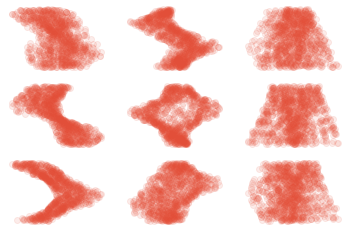

In [27]:
fig, axs = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
            predicted = all_mus[both_in,i].cpu().detach().numpy()
            x = all_xys[0,both_in,j]
            axs[i, j].plot(predicted, x, 'o', alpha=0.1)
            axs[i, j].axis('off')

173056
(64, 64)
173056
(64, 64)
173056
(64, 64)
173056
(64, 64)


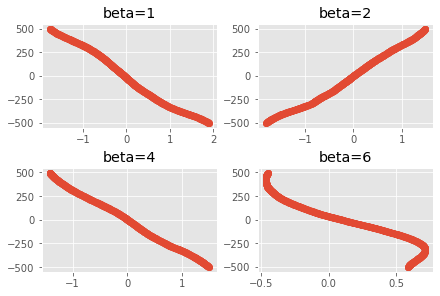

In [278]:
betas = [1, 2, 4, 6]
import seaborn as sb
fig, axs = plt.subplots(2,2, constrained_layout=True)


for j in range(len(betas)):
    model = model_conv_bigger.VAE_CNN_version_2(zDim=1).to(device)
    beta = betas[j]
    model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/Resnet_B{beta}_VAE_z_only_200.pt"))

    images, xys, _ = create_psf_batch(batch_size=10)
    model.eval()
    images = images.to(device)
    reconstruction, mu, logvar = model(images)
    all_xys = xys
    all_mus = mu
    for i in range(100):
        images, xys, _ = create_psf_batch(batch_size=50)
        model.eval()
        images = images.to(device)
        reconstruction, mu, logvar = model(images)
        del reconstruction
        del images

        all_xys = torch.cat((all_xys, xys), dim=1)
        del xys
        all_mus = torch.cat((all_mus, mu), dim=0)


    predicted = all_mus[:,0].cpu().detach().numpy()
    x = all_xys[0,:,2]
    axs[j//2][j%2].plot(predicted, x,'o', alpha=0.1)
    axs[j//2][j%2].set_title(f"beta={betas[j]}")
    


In [271]:
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

tensor(1.2636, device='cuda:0', grad_fn=<MulBackward0>)

(array([284.,  72.,  63.,  51.,  55.,  48.,  31.,  47.,  65., 294.]),
 array([-0.46525842, -0.34745276, -0.2296471 , -0.11184144,  0.00596422,
         0.12376988,  0.24157554,  0.3593812 ,  0.47718686,  0.59499252,
         0.71279818]),
 <BarContainer object of 10 artists>)

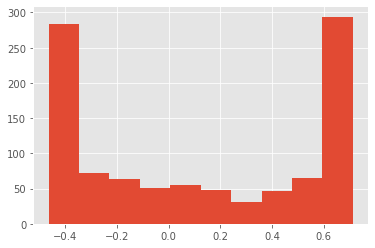

In [269]:
plt.hist(all_mus[:,0].cpu().detach().numpy())

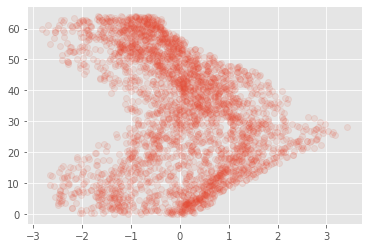

In [183]:
predicted = all_mus[both_in,1].cpu().detach().numpy()
x = all_xys[0,both_in,0]
plt.plot(predicted, x, 'o', alpha=0.1)


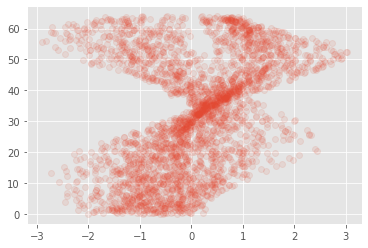

In [182]:
predicted = all_mus[both_in,2].cpu().detach().numpy()
x = all_xys[0,both_in,1]
plt.plot(predicted, x, 'o', alpha=0.1)


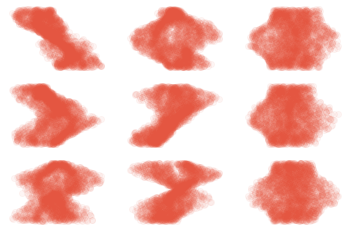

In [ ]:

plt.plot(all_mus[:,1].cpu().detach().numpy(), all_mus[:,2].cpu().detach().numpy(), 'o', alpha=1)

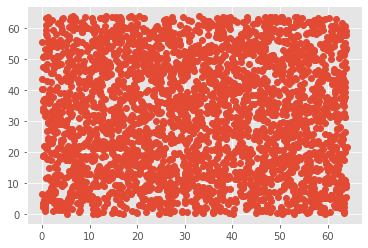

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.plot(all_xys[0,:,0].cpu().detach().numpy(), all_xys[0,:,1].cpu().detach().numpy(), 'o', alpha=1)


In [37]:
images.max()

tensor(2.1374, device='cuda:0')

In [ ]:
#both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                    reconstruction.view(batch_size, 1, 64, 64)[:8]))
#save_image(both.cpu(), f"../outputs/psf_output{epoch}.png", nrow=num_rows)


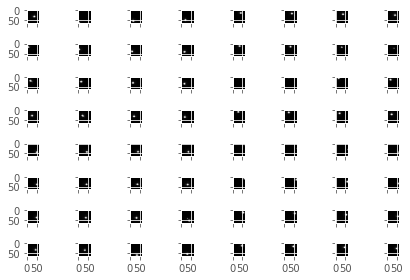

In [144]:
model.eval()
fig, axs = plt.subplots(8,8, sharex=True, sharey=True)
# decoding
fig.tight_layout()
for i in range(-4,4):
    for j in range(-4,4):
        z = torch.tensor([[float(i),float(j)]]).cuda()
        axs[i,j].imshow(reconstruction.view((64, 64)).cpu().detach().numpy(), cmap='gray')

plt.show()


In [137]:
reconstruction.view((64, 64))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0368e-01, 3.2587e-01,
         2.6970e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.7344e-01, 4.9652e-01,
         3.5723e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4673e-01, 8.1915e-01,
         6.0063e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4258e-36, 3.9615e-36,
         4.5398e-36],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4501e-39, 7.5286e-39,
         5.2027e-39],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<ViewBackward0>)

In [156]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from statsmodels.formula.api import ols
predictions = all_mus[both_in,:].cpu().detach().numpy()
X = np.array(all_xys[0,both_in,:2])



train_X, test_X, train_Y, test_Y = skl.model_selection.train_test_split(predictions, X, test_size=0.2)
reg = LinearRegression().fit(np.concatenate([train_X, train_X**2], axis=1), train_Y)
error = np.sqrt(np.mean((reg.predict(np.concatenate([test_X, test_X**2], axis=1)) - test_Y)**2))
print(error)

10.768504


In [154]:
df = pd.DataFrame(np.concatenate([predictions, X], axis=1), columns=["mux", "muy", "X", "Y"])
df

,mux,muy,X,Y
0,0.590835,-1.088881,33.769619,43.261154
1,-0.235529,-0.463075,54.439774,59.142441
2,-0.100780,0.574154,11.446047,17.861872
3,0.686940,-0.091562,28.948713,24.942631
4,-0.082744,0.470603,13.443804,19.228218
...,...,...,...,...
9241,0.283223,-1.349000,38.934818,42.622536
9242,0.330101,-0.425184,28.774563,54.524624
9243,0.308841,0.478308,13.271326,27.912254
9244,-0.767542,2.720012,50.244900,12.440348


In [157]:
model = ols("X, Y ~ mux + muy", data=df)

type: Number of rows mismatch between data argument and X, Y (9246 versus 2)
    X, Y ~ mux + muy
    ^^^^

In [86]:
mus = torch.cat((torch.arange(-2,3,0.5).repeat(10).view(-1,1),torch.arange(-2,3,0.5).repeat_interleave(10).view(-1,1)),1)

In [87]:
model.eval()
z = mus.float().cuda()

reconstruction = model.decoder(z)


In [88]:
save_image(reconstruction.view((10*10, 1, 64,64)).cpu(), f"../outputs/conv_out/psf_beta4_test_values.png", nrow=10, pad_value=1)

In [204]:
reconstruction.shape

torch.Size([169, 4096])

In [64]:
from model_2_layer import simple_nn
simple_model = simple_nn()
lr = 0.001
optimizer_simple = optim.Adam(simple_model.parameters(), lr=lr)
loss_simple = nn.MSELoss()

Hej


In [65]:
def fit_simple(simple_model, train_X, train_Y):
    simple_model.train()
    running_loss = 0.0
    train_X = train_X.to(device)
    train_Y = train_Y.to(device)    
    batch_size = 64
    for i in range(len(train_X)//batch_size):
        data = train_X[i*batch_size:(i+1)*batch_size]
        gt = train_Y[i*batch_size:(i+1)*batch_size]
        optimizer_simple.zero_grad()
        output = simple_model(data)
        loss = loss_simple(output, gt)
        running_loss += loss.item()
        loss.backward()
        optimizer_simple.step()

    train_loss = running_loss/len(train_X)
    return train_loss



In [72]:
def validate_simple(model, test_X, test_y):
    model.eval()
    running_loss = 0.0
    batch_size = 64
    test_X = test_X.to(device)
    test_y = test_y.to(device)    


    with torch.no_grad():
        for i in range(len(test_X)//batch_size):
            data = test_X[i*batch_size:(i+1)*batch_size]
            gt = test_y[i*batch_size:(i+1)*batch_size]
            output = simple_model(data)
            loss = loss_simple(output, gt)
            running_loss += loss.item()

    val_loss = running_loss/len(test_X)
    return val_loss

In [98]:
import sklearn.model_selection as model_selection

predictions = all_mus[both_in,:]
X = all_xys[0,both_in,:2]
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(predictions, X, test_size=0.2, shuffle=True, random_state=42)
#loss_vec = []
#val_loss_vec = []
simple_model.to(device)
train_X = train_X.detach()
test_X = test_X.detach()
for epoch in range(80):
    loss = fit_simple(simple_model, train_X, train_Y)
    loss_vec.append(loss)
    val_loss = validate_simple(simple_model, test_X, test_Y)
    val_loss_vec.append(val_loss)
    

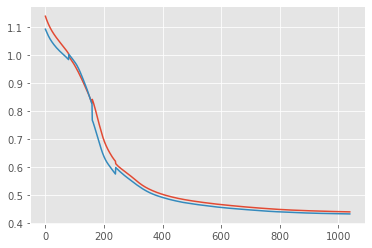

In [99]:
plt.plot(list(range(len(loss_vec))), loss_vec)
plt.plot(list(range(len(loss_vec))), val_loss_vec)

In [101]:
np.sqrt(val_loss_vec[-1])

0.6587733752300137